<a href="https://colab.research.google.com/github/mattcho1157/f1_race_prediction_model/blob/main/prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@ Copyright 2020 Matthew Mingyeom Cho

# **F1 RACE PREDICTION MODEL**

Data science and machine learning play a significant role in Formula 1, especially when determining race strategies ahead of and during a race. This Google Colab notebook walks you through my research project: to build an AI model that uses a deep neural network to predict the grid position results of upcoming F1 Grand Prix races.

## **Overview**

After preprocessing the data and filtering the features engineered in a separate Google Colab notebook (link down below), I trained an initial basic model with 2 hidden layers, which was then evaluated to further refine the data structures and find any abnormal outliers. Subsequently, the hyperparameters of the initial model were tuned via random search to find the optimal model for predicting F1 race results. The accuracy of the final model was 85% - a highly successful result given the volatility and unpredictability of F1 races. Evaluation for potential extensions and improvements to this model have also been explored.

## **Table of contents**
- 1.0 Project environment
- 2.0 Past F1 results dataset
 - 2.1 Inspect the data
- 3.0 Preprocess the data
 - 3.1 A classification problem
 - 3.2 Generate and split the final dataset
 - 3.3 Feature scaling
- 4.0 Initial prediction model
 - 4.1 Train and save the model
 - 4.2 Evaluate the model
- 5.0 Hyperparameter tuning via random search
- 6.0 Final prediction model
 - 6.1 Train and save the model
 - 6.2 Evaluate the model
- 7.0 Extensions and improvements

## **1.0 Project environment**

Working in Google Colab, it was most convenient to store all necessary project files in a Google Drive folder. Hence, to access the files, you must first mount your Google Drive content on your Colab working environment:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the necessary packages:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.constraints import max_norm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## **2.0 Past F1 results dataset**

The first step of building the F1 prediction model was to retrieve relevant features and data for training and testing. Raw data from [Ergast API](http://ergast.com/mrd/) was preprocessed and filtered to generate a final dataset used for this research project. This was done in a separate [Google Colab notebook](https://colab.research.google.com/drive/1JkhxShp6bhhe4lkAcHWAXtMEP0DI2XyI?usp=sharing) and saved as a CSV file in my Google Drive folder. Load the first 5 rows of the dataset:

In [ ]:
data_raw = pd.read_csv('/content/drive/My Drive/f1_prediction/data.csv')
data = data_raw.copy()
data.head()

,race_id,driver_id,start_pos,gap_to_pole,cs_driver_results_missing,cs_driver_standing,cs_driver_podium_rate,csa_pos_change,csa_finish_pos,p3s_driver_results_missing,p3sa_pos_change_same_circuit,p3sa_finish_pos_same_circuit,cs_const_results_missing,cs_const_standing,cs_const_podium_rate,circuit_avg_pos_change,finish_pos
0,18,1,1,0.000,1,0,0.0,0.0,0.0,0,1.0,3.0,1,0,0.0,-1.24,1
1,18,2,5,0.075,1,0,0.0,0.0,0.0,0,1.5,4.0,1,0,0.0,0.67,2
2,18,3,7,0.198,1,0,0.0,0.0,0.0,0,5.0,7.0,1,0,0.0,-0.60,3
3,18,4,11,0.227,1,0,0.0,0.0,0.0,0,4.0,2.0,1,0,0.0,3.93,4
4,18,5,3,0.060,1,0,0.0,0.0,0.0,0,3.0,10.0,1,0,0.0,-0.95,5


### **2.1 Inspect the data**

Since `race_id` and `driver_id` have no significance in determining the results of F1 races, exclude the two columns for data inspection:

In [ ]:
inspection_data = data.iloc[:, 2:]

Overall statistics show the distribution of feature variables:

In [ ]:
data_stats = inspection_data.describe()
data_stats = data_stats.transpose()
data_stats

,count,mean,std,min,25%,50%,75%,max
start_pos,6008.0,10.654461,6.268620,0.0,5.00000,10.000,16.00000,26.0
gap_to_pole,6008.0,0.343519,0.279347,0.0,0.12075,0.274,0.50225,1.0
cs_driver_results_missing,6008.0,0.103362,0.304457,0.0,0.00000,0.000,0.00000,1.0
cs_driver_standing,6008.0,9.633489,6.993885,0.0,3.00000,9.000,15.00000,31.0
cs_driver_podium_rate,6008.0,0.170699,0.292606,0.0,0.00000,0.000,0.25000,1.0
csa_pos_change,6008.0,1.612109,2.557920,-11.0,0.00000,1.200,3.00000,17.0
csa_finish_pos,6008.0,7.841275,4.947897,0.0,3.90000,8.000,11.36000,23.0
p3s_driver_results_missing,6008.0,0.385652,0.486790,0.0,0.00000,0.000,1.00000,1.0
p3sa_pos_change_same_circuit,6008.0,0.896045,2.822021,-15.0,0.00000,0.000,2.00000,18.0
p3sa_finish_pos_same_circuit,6008.0,4.796247,5.095313,0.0,0.00000,3.500,8.50000,24.0


As shown above, there are 6008 rows of data. As well, the mean and standard deviation of the variables vary significantly, suggesting that feature scaling must be applied to prevent feature bias during training and quicken optimisation algorithms.

Plot the relationship between each feature variable and `finish_pos`:

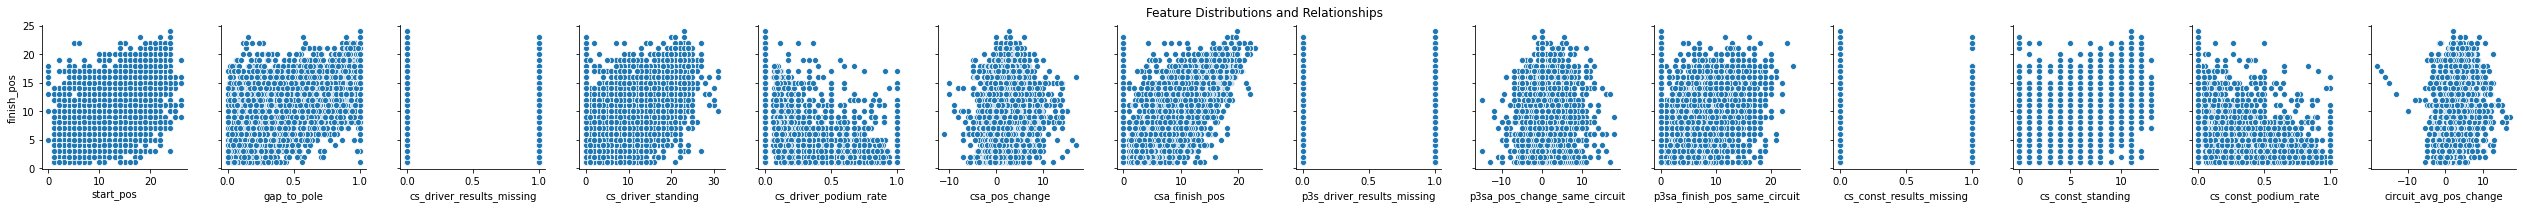

In [ ]:
sns.pairplot(data=inspection_data,
             y_vars=['finish_pos'],
             x_vars=inspection_data.iloc[:, :-1].columns.values.tolist())
plt.suptitle('Feature Distributions and Relationships', y=1.08)
plt.show()

The above plot graphs show that the 6008 data points are evenly distributed across the possible values (range) of each feature variable. Note that `cs_driver_results_missing`, `p3s_driver_results_missing` and `cs_const_results_missing` columns are missing-data indicators (i.e. they are booleans with 0 and 1 being the only possible values).



Count the frequency of each `finish_pos` value:

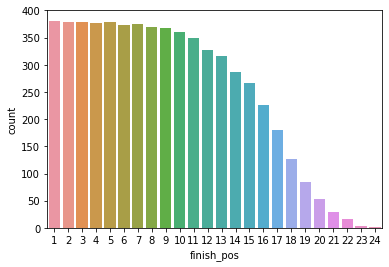

In [ ]:
sns.countplot(x='finish_pos', data=inspection_data)
plt.show()

The 6008 data points are roughly equally distributed for finish positions 1 to 10, which is favourable. However, from 10 onwards, the number of data points decreases. This is expected, as numerous cars back in the 1900s were not able to finish races due to mechanical or strategical complications (i.e. 10 or fewer cars ended up attaining a `finish_pos` value). As well, only in recent years has F1 constrained the number of cars on the starting grid to 20. Such variability may have led to slightly noisy data.

## **3.0 Preprocess the data**

Prior to training the model, the data needs to be pre-processed to address 3 key stages in enhancing the model-training:
- increasing the number of data points
- employing a classification problem approach
- feature scaling

### **3.1 A classification problem**

Why classification instead of regression? If this was approached as a regression problem, then the prediction model must predict the exact finishing grid position of each driver given their current and past performance levels. This leads to a few issues:
- Values for each feature may vary in significance and meaning across different eras and circuits (e.g. it is much harder to overtake a certain number of cars at the Monaco track as it is a narrow street circuit), meaning that a regression model will not be able to accurately predict a finishing grid position merely from raw performance indicators (it will not be able to pick up the intricate qualities of each era and circuit with such limited data).
- A regression model outputs a real number not bounded by a range (unless output normalisation is applied), which may result in outputs being greater than the total number of cars on the grid (e.g. predicting a 25th place finish when there are only 20 cars on the track).
- Since a regression model treats each driver separately, it may predict the same finishing position for more than one driver, leading to duplicate outputs in the same race.

To address the three key issues above, this prediction model was approached as a classification problem. This is how it works:
1. For each possible pair of drivers on the grid in a particular race, label them Driver A and Driver B.
2. Find the difference in the to driver's performance levels by subtracting the feature values of Driver B from that of Driver A. These are the input variables (which requires a new dataset to be generated, as shown further down).
3. The model's output will be a boolean value: 1 if Driver A wins, 0 if Driver A loses or there's a draw.

By comparing the performance indicators of each driver pair, there is no need to consider the era and circuit of each race during training because Driver A and Driver B will be participating in the same race. As well, the newly generated dataset that's suitable for a classification problem will contain a lot more rows of data than the current dataset (which only has 6008 data points), allowing greater efficacy in using a deep learning model.

Column names for the new dataset:

In [ ]:
column_names = data.columns.values.tolist()[2:-1] + ['win']

Function for calculating the differences in driver performance features between Drivers A and B, and a 0/1 output value indicating the winner:

In [ ]:
def subtract_driver_features(driver_features):
    # store rows containing the differences between features of driver A and driver B
    feature_differences = []

    for driver_A in driver_features.itertuples(index=False, name='DriverA'):
        # results of drivers who partook in the same race as driver A
        drivers_same_race = driver_features[driver_features['race_id'] == getattr(driver_A, 'race_id')]
        
        for driver_B in drivers_same_race.itertuples(index=False, name='DriverB'):
            # driver A cannot be the same driver as driver B
            if getattr(driver_A, 'driver_id') == getattr(driver_B, 'driver_id'):
                continue
            
            # finding the difference between the features of drivers A and B
            # note: race_id and driver_id columns can now be discarded
            drivers_difference = np.subtract(driver_A, driver_B)[2:]

            # difference in finish_pos of drivers A and B
            finish_pos_difference = drivers_difference[-1]
            # if finish_pos_difference < 0, then driver A beat driver B (model output = 1)
            # otherwise, driver B beat driver A (model output = 0)
            drivers_difference[-1] = int(finish_pos_difference < 0)
        
            feature_differences.append(drivers_difference)

    feature_differences = pd.DataFrame(feature_differences, columns=column_names) 
    return feature_differences

### **3.2 Generate and split the final dataset**

Using the function defined above, the new dataset is generated, which is then split into the following sets:
- `test_1` set only contains data for races 1, 6, 11, 16 and 21 of the 2019 season. This test set will be used for evaluating the "grid-place" accuracy of the model (i.e. how accurately the model predicts the finishing grid places of a race)
- `test_2` set contains the test data for evaluating the "win/lose" accuracy of the model (i.e. how accurately the model predicts whether Driver A wins or loses against Driver B)
- `train` set contains the rest of the dataset used for model training

Each of the three test and train datasets was further split into input (X) and output (y) arrays.

In [ ]:
# test_1 set comprises races 1, 6, 11, 16 and 21 of the 2019 season
races = pd.read_csv('/content/drive/My Drive/f1_prediction/data/races.csv')
test_1_race_ids = races[(races['year'] == 2019) & (races['round'].isin([1, 6, 11, 16, 21]))]['race_id']
# extract test_1 set from the entire dataset and perform driver feature subtraction
test_1 = data[data['race_id'].isin(test_1_race_ids)]
test_1 = subtract_driver_features(test_1)
# split test_1 into its input and output features
X_test_1 = test_1.iloc[:, :-1]
y_test_1 = test_1.iloc[:, -1]

# perform driver feature subtraction on the remaining dataset (i.e. non-test_1 set)
remaining_data = data[~data['race_id'].isin(test_1_race_ids)]
remaining_data = subtract_driver_features(remaining_data)
# split remainig_data into its input and output features
X_remaining_data = remaining_data.iloc[:, :-1]
y_remaining_data = remaining_data.iloc[:, -1]

# split remaining_data into the input and output features of test_2 and training sets
from sklearn.model_selection import train_test_split
X_train, X_test_2, y_train, y_test_2 = train_test_split(X_remaining_data.copy(), 
                                                        y_remaining_data.copy(), 
                                                        test_size=0.08, random_state=1)

# concatenate test_1 and test_2 arrays of input and output features
X_test = pd.concat([X_test_1, X_test_2])
y_test = pd.concat([y_test_1, y_test_2])

# reorder dataframe indices
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

The new dataset is not only suited for a classification problem, but also has significantly more rows of data (93030 rows - training and testing set combined) than the previous dataset (6008 rows):

In [ ]:
print('Training set size:', y_train.shape[0])
print('Testing set size:', y_test.shape[0])

Training set size: 84686
Testing set size: 8344


### **3.3 Feature scaling**

Feature scaling has two major benefits: it (1) prevents bias towards certain features and (2) quickens the optimisation process during model training. For this model, standardisation is used as the feature scaling method - subtracting the mean from the feature values and dividing the result by the standard deviation:

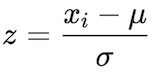

This results in a Gaussian distribution with 0 mean and unit variance. Note that the missing-data indicator columns are not scaled: 0 and 1 are discrete boolean values.

In [ ]:
# standardising input data
from sklearn.preprocessing import StandardScaler

# exclude missing-data columns for feature scaling
columns_without_missing = ['start_pos', 'gap_to_pole', 'cs_driver_standing', 'cs_driver_podium_rate', 'csa_pos_change', 
                           'csa_finish_pos', 'p3sa_pos_change_same_circuit', 'p3sa_finish_pos_same_circuit', 
                           'cs_const_standing', 'cs_const_podium_rate', 'circuit_avg_pos_change']
# fit the standardiser to the training set
scaler = StandardScaler().fit(X_train[columns_without_missing])
# scale the training and test set
X_train[columns_without_missing] = scaler.transform(X_train[columns_without_missing])
X_test[columns_without_missing] = scaler.transform(X_test[columns_without_missing])

An example row of data with standardised feature values:

In [ ]:
i = random.randint(0, y_train.shape[0] - 1)
print('Input:\n' + str(X_train.iloc[i, :]), '\n')
print('Output:', y_train.iloc[i])

Input:
start_pos                      -0.776755
gap_to_pole                    -1.861522
cs_driver_results_missing       0.000000
cs_driver_standing             -1.414741
cs_driver_podium_rate           0.412201
csa_pos_change                 -0.437544
csa_finish_pos                 -1.312250
p3s_driver_results_missing     -1.000000
p3sa_pos_change_same_circuit   -0.249252
p3sa_finish_pos_same_circuit    1.044301
cs_const_results_missing        0.000000
cs_const_standing              -1.351799
cs_const_podium_rate            0.315203
circuit_avg_pos_change         -0.941626
Name: 50819, dtype: float64 

Output: 0.0


## **4.0 Initial prediction model**

An initial model is built for two major reasons:
1. detect and omit any obsolete or skewed features
2. its accuracy figures can be compared to those of the final model after hyperparameter tuning to observe any improvements

### **4.1 Train and save the model**

The initial model has 2 hidden layers, with 16 neurons in each layer. The ReLU (Rectified Linear Unit) activation function is used for the hidden layers to quicken the optimisation process, and the sigmoid function for the output layer to allow binary classification. Xavier (Glorot) normal initialisation was used for every layer to reduce the possibility of attaining false local minima. Being a classification problem, binary cross-entropy was calculated as the loss function and the Adam optimisation algorithm was implemented.

The training involved 100 epochs with a batch size of 256.

In [ ]:
initial_model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(14,), kernel_initializer='glorot_normal'),
    keras.layers.Dense(16, activation='relu', kernel_initializer='glorot_normal'),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')])

initial_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

history = initial_model.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size=256, verbose=0)

Define a function for plotting the accuracy and loss graphs over the number of epochs during model training:

In [ ]:
# plotting graph of metrics history
def plot_metrics_history(history, metrics):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_' + metrics])
    plt.ylabel(metrics)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

Accuracy vs Epoch graph for the training and validation set:

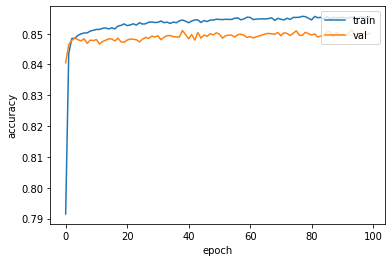

In [ ]:
# plot accuracy graph
plot_metrics_history(history, 'accuracy')

Loss vs Epoch graph for the training and validation set:

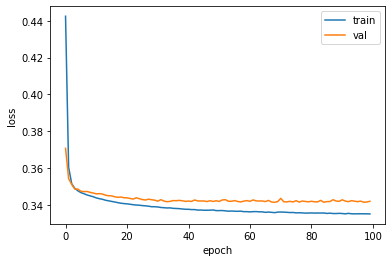

In [ ]:
# plt loss graph
plot_metrics_history(history, 'loss')

As shown by the loss function graph above, the training set loss continues to decrease while the validation set loss begins to increase after around 60 epochs (an elbow-shaped curve). This indicates that the model overfitted, meaning it began to learn the training dataset too well, including random fluctuations or statistical noise in the training dataset, and is less able to generalise to new data. Furthermore, there is a possibility that the model converged to a local minimum, not a global minimum.

Save this initial model into Google Drive in the SavedModel format (this allows compatibility with Tensorflow Serving, which may be needed should I decide to implement this model into an online AI startup):

In [ ]:
# save initial model
!mkdir -p saved_model
initial_model.save('/content/drive/My Drive/f1_prediction/saved_model/initial_model') 

INFO:tensorflow:Assets written to: /content/drive/My Drive/f1_prediction/saved_model/initial_model/assets


### **4.2 Evaluate the model**

It is crucial to evaluate the initial model to (1) detect and omit any obsolete or skewed features and (2) compare its accuracy figures to those of the final model after hyperparameter tuning to observe any improvements. Four key evaluation metrics were used: test accuracy, confusion matrix (which was then used to calculate precision, recall and F1 score), output distribution curves, and output vs feature value curves.

Load the saved initial model from Google Drive (since it was already saved, there is no need to train the model again). A summary of the model structure is outlined below:

In [ ]:
initial_model = tf.keras.models.load_model('/content/drive/My Drive/f1_prediction/saved_model/initial_model')
initial_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 16)                240       
_________________________________________________________________
dense_22 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________


Predict the outputs of the `X_test` set, having 0.5 as the binary classification threshold. The 0.5 threshold is only used for the initial model for a rough estimation. For the final model, an optimal threshold is determined using a ROC curve.

In [ ]:
predictions = initial_model.predict(X_test).flatten()
classifications = np.round(predictions)

1) By evaluating the model on the test set, it can be seen that its test accuracy is 84%. Considering that this is an initial model with a basic neural network structure, 84% is a rather high accuracy figure, suggesting that the patterns in the data may not be too complicated.

In [ ]:
test_loss, test_acc = initial_model.evaluate(X_test, y_test, verbose=0)
print('test accuracy:', test_acc)

test accuracy: 0.8461169600486755


2) A confusion matrix can be used to calculate the precision, recall and F1 score for the initial model. As shown below, all three metrics are 0.84, suggesting that the 0.5 threshold for the initial model is optimal (i.e. no trade-off has to be made between recall and precision as they are already equal). As well, the number of false negatives and false positives are roughly similar (around 640), as with the number of true positives and true negatives (around 3500). This indicates that the model is equally likely to predict the two classes (0: Driver A loses, 1: Driver A wins) incorrectly, meaning that there is no bias towards one specific class.

In [ ]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_test, classifications)
true_pos = c_matrix[0][0]
false_neg = c_matrix[0][1]
false_pos = c_matrix[1][0]
precision = round(true_pos / (true_pos + false_pos), 2)
recall = round(true_pos / (true_pos + false_neg), 2)
f1_score = round(2 * ((precision * recall) / (precision + recall)), 2)

print('Confusion Matrix:\n', c_matrix)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

Confusion Matrix:
 [[3458  637]
 [ 647 3602]]
Precision: 0.84
Recall: 0.84
F1 Score: 0.84


3) The output distribution curves below show the spread of model outputs for class 0 (Driver A loses) and class 1 (Driver A wins). As illustrated, most of the outputs for data belonging to class 0 and class 1 are concentrated around 0.0 and 1.0 respectively, suggesting that the model is highly accurate in terms of output distribution.

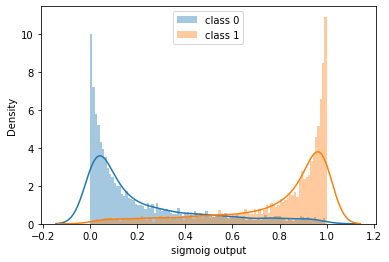

In [ ]:
predictions_win = []
predictions_lose = []

for i in range(len(predictions)):
    if y_test[i] == 0:
        predictions_lose.append(predictions[i])
    else:
        predictions_win.append(predictions[i])

sns.distplot(predictions_lose, bins=100, label="class 0")
sns.distplot(predictions_win, bins=100, label="class 1")
plt.xlabel("sigmoig output")
plt.legend()
plt.show()

4) The output vs feature value curves below (drawn using kernel density estimate plots) illustrate the distribution of loss (class 0) and win (class 1) outputs against the range of values for each feature. For instance, the output vs `start_pos` curve (first graph below) shows that a negative difference in `start_pos` (remember, each of the feature variables are actually the differences in feature values between Drivers A and B) corresponds with Driver A winning, whereas a positive difference in `start_pos` corresponds with Driver A losing. This is to be expected, as a negative `start_pos` difference means Driver A starts ahead of Driver B, and thus is more likely to finish ahead as well.

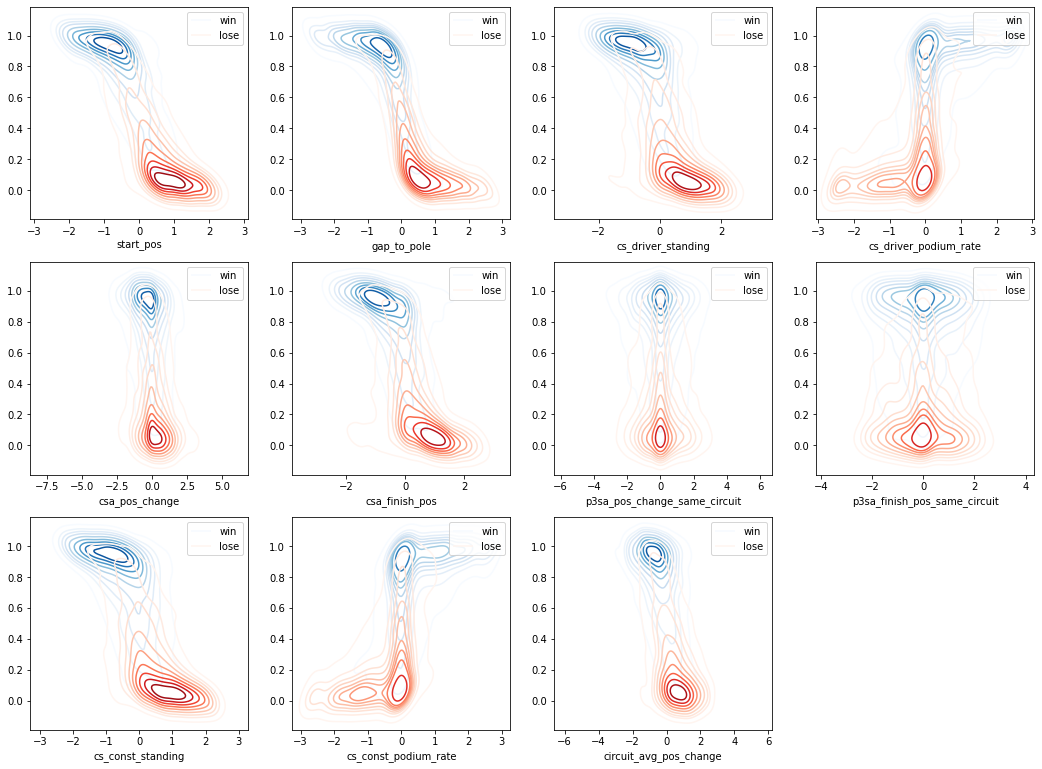

In [ ]:
fig = plt.figure(figsize=(18, 18))
for x, feature in enumerate(columns_without_missing):
    predictions_win = []
    predictions_lose = []
    feature_win = []
    feature_lose = []
    for i in range(len(predictions)):
        if y_test[i] == 0:
            predictions_lose.append(predictions[i])
            feature_lose.append(float(X_test.loc[i, [feature]]))
        else:
            predictions_win.append(predictions[i])
            feature_win.append(float(X_test.loc[i, [feature]]))
    ax = fig.add_subplot(4, 4, x+1)
    ax.set_xlabel(feature)
    sns.kdeplot(feature_win, predictions_win, label="win",
                 cmap="Blues", ax=ax)
    sns.kdeplot(feature_lose, predictions_lose, label="lose",
                 cmap="Reds", ax=ax)
    plt.legend(loc='upper right')
plt.show()

As with the `start_pos` curve, most of the distribution curves above matched their respective theoretical expectations, except for the following features: `p3sa_pos_change_same_circuit` and `p3sa_finish_pos_same_circuit`. In both curves, the feature values appear to have no influence on the model output (i.e. there are similar numbers of win and loss predictions for each possible feature value), suggesting that the two features are redundant. Hence, they were omitted from the list of columns in the dataset, as shown below: 

In [ ]:
col = ['start_pos', 'gap_to_pole', 'cs_driver_results_missing', 'cs_driver_standing', 'cs_driver_podium_rate', 'csa_pos_change',
       'csa_finish_pos', 'cs_const_results_missing', 'cs_const_standing', 'cs_const_podium_rate', 'circuit_avg_pos_change']
X_train = X_train.loc[:, col]
X_test = X_test.loc[:, col]

## **5.0 Hyperparameter tuning via random search**

In order to optimise the model's performance, its hyperparameters must be tuned. For this specific research project, random search was used instead of a grid search for more effective hyperparameter tuning. Along with hyperparameter tuning, 5-fold cross validation was also implemented due to the limited number of data points and to prevent overfitting. TensorFlow's HParams Dashboard was used to find the optimal parameters after the random search.

Load the TensorBoard notebook extension and TensorBoard HParams plugin:

In [ ]:
# load the TensorBoard notebook extension
%load_ext tensorboard
# clear any logs from previous runs
!rm -rf ./logs/ 

# import TensorBoard HParams plugin
from tensorboard.plugins.hparams import api as hp

For this random search, nine hyperparameters were tested:
- number of hidden layers (2, 3, 4)
- number of neurons in each hidden layer (4, 8, 16, 32, 64, 128, 256, 512)
- optimiser algorithm (adam, rmsprop, sgd)
- learning rate (0.001, 0.01, 0.1, 0.3,  0.5)
- momentum (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)
- dropout rate (0.3, 0.4, 0.5, 0.6, 0.7, 0.8)
- weight constraint (1, 2, 3, 4, 5)
- weight initialiser (normal, he_normal, he_uniform, glorot_normal, glorot_uniform)
- batch size (32, 64, 128, 256, 512, 1024, 2048)

After listing the values to test, an experiment configuration was logged onto TensorBoard:

In [ ]:
HP_HIDDEN_LAYERS = hp.HParam('hidden_layers', hp.IntInterval(2, 4))
HP_HL1_NEURONS = hp.HParam('HL1_neurons', hp.Discrete([4, 8, 16, 32, 64, 128, 256, 512]))
HP_HL2_NEURONS = hp.HParam('HL2_neurons', hp.Discrete([4, 8, 16, 32, 64, 128, 256, 512]))
HP_HL3_NEURONS = hp.HParam('HL3_neurons', hp.Discrete([4, 8, 16, 32, 64, 128, 256, 512]))
HP_HL4_NEURONS = hp.HParam('HL4_neurons', hp.Discrete([4, 8, 16, 32, 64, 128, 256, 512]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop', 'sgd']))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.001, 0.01, 0.1, 0.3,  0.5]))
HP_MOMENTUM = hp.HParam('momentum', hp.Discrete([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
HP_DROPOUT_RATE = hp.HParam('dropout_rate', hp.Discrete([0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))
HP_WEIGHT_CONSTRAINT = hp.HParam('weight_constraint', hp.IntInterval(1, 5))
HP_WEIGHT_INIT = hp.HParam('weight_init', hp.Discrete(['normal', 'he_normal', 'he_uniform','glorot_normal', 'glorot_uniform']))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([32, 64, 128, 256, 512, 1024, 2048]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_HIDDEN_LAYERS, HP_HL1_NEURONS, HP_HL2_NEURONS, HP_HL3_NEURONS, HP_HL4_NEURONS,
                 HP_OPTIMIZER, HP_LEARNING_RATE, HP_MOMENTUM, HP_DROPOUT_RATE, 
                 HP_WEIGHT_CONSTRAINT, HP_WEIGHT_INIT, HP_BATCH_SIZE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

The `cross_validate_model(hparams)` function below is what actually manages the hyperparameter tuning. The model training code is similar to the training code used for the initial model, although the hyperparameters are no longer hardcoded. Instead, they are provided in an HParams dictionary and used throughout the training function. Once the model is built, 5-fold cross validation is used to further split the training set into 5 subsets. The model is then iteratively trained on one of the 4 folds and evaluated on the 5th fold. At the very end of the training, the performances across the 5 folds are averaged to determine a final validation accuracy for the model.

A maximum of 500 epochs is set, although the training is set to stop when the validation accuracy does not improve for 20 epochs in order to prevent overfitting (high variance).

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
X_kfold = X_train.to_numpy()
y_kfold = y_train.to_numpy()

def cross_validate_model(hparams):
    hidden_neurons = [hparams[HP_HL1_NEURONS], hparams[HP_HL2_NEURONS], hparams[HP_HL3_NEURONS], hparams[HP_HL4_NEURONS]]

    model = keras.Sequential()
    model.add(keras.layers.Dense(hidden_neurons[0], activation='relu', 
                                 input_shape=(11,), kernel_initializer=hparams[HP_WEIGHT_INIT], 
                                 kernel_constraint=max_norm(hparams[HP_WEIGHT_CONSTRAINT])))
    model.add(keras.layers.Dropout(hparams[HP_DROPOUT_RATE]))
    
    for L in range(1, hparams[HP_HIDDEN_LAYERS]):
        model.add(keras.layers.Dense(hidden_neurons[L], activation='relu', 
                                     kernel_initializer=hparams[HP_WEIGHT_INIT], 
                                     kernel_constraint=max_norm(hparams[HP_WEIGHT_CONSTRAINT])))
        model.add(keras.layers.Dropout(hparams[HP_DROPOUT_RATE]))
    
    model.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=hparams[HP_WEIGHT_INIT]))

    optimizer = hparams[HP_OPTIMIZER]
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE])
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hparams[HP_LEARNING_RATE], momentum=hparams[HP_MOMENTUM])
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=hparams[HP_LEARNING_RATE], momentum=hparams[HP_MOMENTUM])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    kfold_accuracies = []
    for train_index, test_index in kfold.split(X_kfold):
        X_train, X_test, y_train, y_test = X_kfold[train_index], X_kfold[test_index], y_kfold[train_index], y_kfold[test_index]
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
        model.fit(X_train, y_train, epochs=500, validation_split = 0.2, batch_size=hparams[HP_BATCH_SIZE], verbose=2, callbacks=[early_stop])
        _, accuracy = model.evaluate(X_test, y_test)
        kfold_accuracies.append(accuracy)

    return np.mean(kfold_accuracies)

For each run, log an HParams summary with the hyperparameters and final accuracy:

In [ ]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = cross_validate_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

The below for-loop runs 80 iterations of hyperparameter tuning (i.e. tests 80 different models) using random search, as indicated by `.domain.sample_uniform()` for each parameter. After each iteration, the test accuracy is saved onto TensorBoard.

In [ ]:
num_iterations = 80

for iteration in range(num_iterations):
    hparams = {
        HP_HIDDEN_LAYERS : HP_HIDDEN_LAYERS.domain.sample_uniform(),
        HP_HL1_NEURONS : HP_HL1_NEURONS.domain.sample_uniform(),
        HP_HL2_NEURONS : HP_HL2_NEURONS.domain.sample_uniform(),
        HP_HL3_NEURONS : HP_HL3_NEURONS.domain.sample_uniform(),
        HP_HL4_NEURONS : HP_HL4_NEURONS.domain.sample_uniform(),
        HP_OPTIMIZER : HP_OPTIMIZER.domain.sample_uniform(),
        HP_LEARNING_RATE : HP_LEARNING_RATE.domain.sample_uniform(),
        HP_MOMENTUM : HP_MOMENTUM.domain.sample_uniform(),
        HP_DROPOUT_RATE : HP_DROPOUT_RATE.domain.sample_uniform(),
        HP_WEIGHT_CONSTRAINT : HP_WEIGHT_CONSTRAINT.domain.sample_uniform(),
        HP_WEIGHT_INIT : HP_WEIGHT_INIT.domain.sample_uniform(),
        HP_BATCH_SIZE : HP_BATCH_SIZE.domain.sample_uniform()}

    run_name = "run-%d" % (iteration+1)
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/' + run_name, hparams)

Open the HParams dashboard via TensorBoard to display the hyperparameter tuning results (a screenshot of a small segment of the results table was inserted below instead of the actual table because TensorBoard erases all of its data shortly after hyperparameter tuning):

In [ ]:
%tensorboard --logdir logs/hparam_tuning

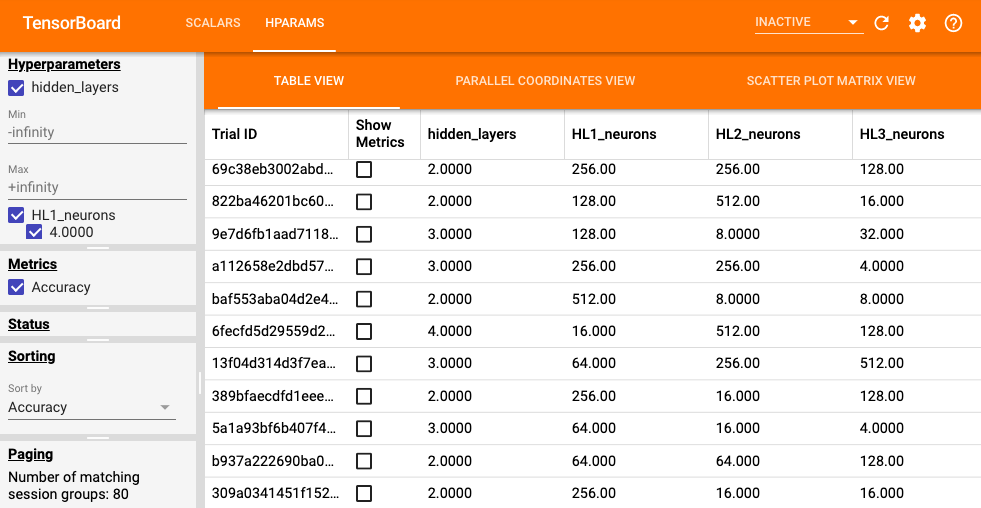

From the HParams random search, the optimal hyperparameters were found as below:

- hidden layers (HL): 2
- HL1 neurons: 256
- HL2 neurons: 256
- optimizer: rmsprop
- learning rate: 0.001
- momentum: 0.1
- dropout rate: 0.4
- weight constraint: 3
- weight init: glorot_uniform
- batch size: 128

ACCURACY: 0.85372

## **6.0 Final prediction model**

### **6.1 Train and save the model**

Using the optimal hyperparameters tuned above, a new final model can be trained, as shown below. The maximum number of epochs is set to 500, although early stopping is implemented (i.e. if the validation accuracy does not improve for 10 epochs, training automatically stops) to prevent overfitting to the training data.

In [ ]:
final_model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(11,), 
                       kernel_initializer='glorot_uniform', kernel_constraint=max_norm(3)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(256, activation='relu', 
                       kernel_initializer='glorot_uniform', kernel_constraint=max_norm(3)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.1)

final_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = final_model.fit(X_train, y_train, epochs=500, validation_split = 0.2, batch_size=128, verbose=2, callbacks=[early_stop])

Accuracy vs Epoch graph for the training and validation set:

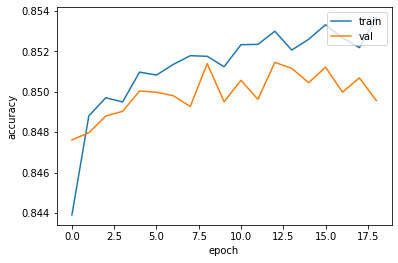

In [ ]:
# plot accuracy graph
plot_metrics_history(history, 'accuracy')

Loss vs Epoch graph for the training and validation set:

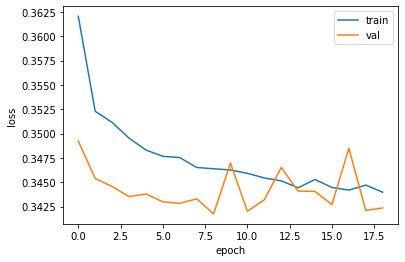

In [ ]:
# plt loss graph
plot_metrics_history(history, 'loss')

As shown by the loss function graph above, both the validation and test set accuracies decrease to a certain point before training stops. The fluctuations in the graphs may have been caused by the implementation of dropout - dropout causes your network to keep only some portion of neurons/weights on each iteration, meaning some of the neurons may not fit certain mini-batches well. Furthermore, as expected, training set accuracy is slightly higher than the validation set accuracy, but their losses equal out after a few epochs, suggesting that the final prediction model has no significant bias or variance.

Save this final model into Google Drive in the SavedModel format (this allows compatility with Tensorflow Serving, which may be needed should I decide to implement this model into an online AI startup):

In [ ]:
# save final model
!mkdir -p saved_model
final_model.save('/content/drive/My Drive/f1_prediction/saved_model/final_model') 

### **6.2 Evaluate the model**

Evaluating the final model ensures that a noticeable improvement from the initial model via hyperparameter tuning is observed. As with the evaluation of the initial model, four key evaluation metrics were used: test accuracy, confusion matrix (which was then used to calculate precision, recall and F1 score), output distribution curves, and output vs feature value curves. A ROC curve was also used to determine the optimal threshold for the final model's binary classification.

Load the saved final model from Google Drive (since it was already saved, there is no need to train the model again):

In [ ]:
final_model = tf.keras.models.load_model('/content/drive/My Drive/f1_prediction/saved_model/final_model')

Feed the `X_test` set to the model for predictions (outputs a real number from 0 to 1):

In [ ]:
predictions = final_model.predict(X_test).flatten()

As shown below, a ROC curve is plotted to find the optimal output threshold for this model's binary classification. A ROC (receiver operating characteristic) curve by definition is a "graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied." Specifically, it is a graph that plots the model's true positive rate against the false positive rate as the threshold is varied.

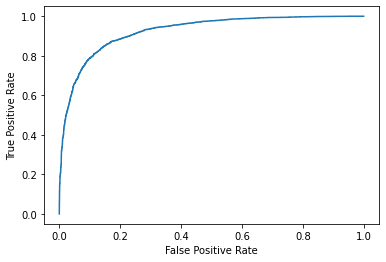

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Using the ROC curve above, the optimal threshold for this binary classification model can be found (the point at which the true positive rate and false positive rate are concurrently maximised):

In [ ]:
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print('optimal threshold:', optimal_threshold)

optimal threshold: 0.50006753


Generate binary class predictions using the 0.50006753 threshold attained from above:

In [ ]:
def y_pred(predictions):
    y_pred = np.where(predictions > optimal_threshold, 1, 0)
    return y_pred

y_pred = y_pred(predictions)

1) By evaluating the final model on the test set, it can be seen that its test accuracy is 85%. This is only a 1% improvement from the initial model after hyperparameter tuning, possibly suggesting that the remaining 15% of the data (that the model predicted incorrectly) are noisy. This is highly likely given the randomness of some F1 results; for instance, a car starting 15th on the grid could end up finishing in the top 3 if the majority of the mid-field cars suffer mechanical failures. Another possibility is that the 15% of the dataset are data pertaining to past eras of F1 and thus may not be consistent with the data patterns of modern races. But the model accuracy improved nonetheless, which is favourable.

In [ ]:
test_acc = tf.keras.metrics.binary_accuracy(y_test, y_pred, threshold=optimal_threshold)
print('test accuracy:', float(test_acc))

test accuracy: 0.8513902425765991


2) A confusion matrix can be used to calculate the precision, recall and F1 score for the initial model. Although the model's recall and F1 score remained unchanged at 0.84, its precision increased by 0.01 (from 0.84 to 0.85). As well, similar to the initial model, the number of false negatives and false positives are roughly similar (around 620), as with the number of true positives and tru negatives (around 3500). This indicates that the model is equally likely to predict the two classes (0: Driver A loses, 1: Driver A wins) incorrectly, meaning that there is no bias towards one specific class.

In [ ]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_test, y_pred)
true_pos = c_matrix[0][0]
false_neg = c_matrix[0][1]
false_pos = c_matrix[1][0]
precision = round(true_pos / (true_pos + false_pos), 2)
recall = round(true_pos / (true_pos + false_neg), 2)
f1_score = round(2 * ((precision * recall) / (precision + recall)), 2)

print('Confusion Matrix:\n', c_matrix)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

Confusion Matrix:
 [[3450  645]
 [ 595 3654]]
Precision: 0.85
Recall: 0.84
F1 Score: 0.84


3) The output distribution curves below show the spread of model outputs for class 0 (Driver A loses) and class 1 (Driver A wins). As illustrated, most of the outputs for data belonging to class 0 and class 1 are concentrated around 0.0 and 1.0 respectively, suggesting that the model is highly accurate in terms of output distribution. Furthermore, the distribution curve is an improvement from the initial model, as a higher percentage of the predictions are packed more tightly around their corresponding classes (0 or 1), suggesting that the model predicts race results with greater confidence.

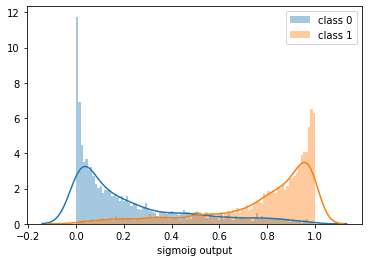

In [ ]:
predictions_win = []
predictions_lose = []

for i in range(len(predictions)):
    if y_test[i] == 0:
        predictions_lose.append(predictions[i])
    else:
        predictions_win.append(predictions[i])

sns.distplot(predictions_lose, bins=100, label="class 0")
sns.distplot(predictions_win, bins=100, label="class 1")
plt.xlabel("sigmoig output")
plt.legend()
plt.show()

4) The output vs feature value curves below (drawn using kernel density estimate plots) illustrate the distribution of loss (class 0) and win (class 1) outputs against the range of values for each feature. For instance, the output vs `start_pos` curve (first graph below) shows that a negative difference in `start_pos` (remember, each of the feature variables are actually the differences in feature values between Drivers A and B) corresponds with Driver A winning, whereas a positive diffrence in `start_pos` corresponds with Driver A losing. This is to be expected, as a negative `start_pos` difference means Driver A starts ahead of Driver B, and thus is more likely to finish ahead as well.

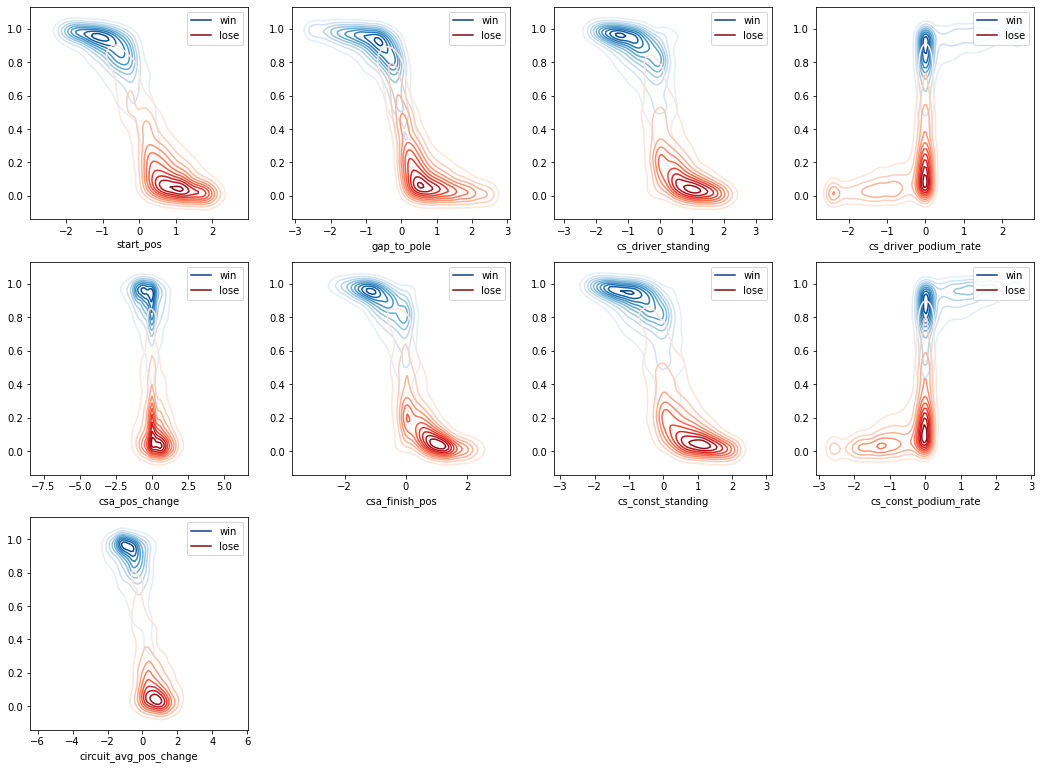

In [ ]:
new_col = ['start_pos', 'gap_to_pole', 'cs_driver_standing', 'cs_driver_podium_rate', 'csa_pos_change',
           'csa_finish_pos', 'cs_const_standing', 'cs_const_podium_rate', 'circuit_avg_pos_change']

fig = plt.figure(figsize=(18, 18))
for x, feature in enumerate(new_col):
    predictions_win = []
    predictions_lose = []
    feature_win = []
    feature_lose = []
    for i in range(len(predictions)):
        if y_test[i] == 0:
            predictions_lose.append(predictions[i])
            feature_lose.append(float(X_test.loc[i, [feature]]))
        else:
            predictions_win.append(predictions[i])
            feature_win.append(float(X_test.loc[i, [feature]]))
    ax = fig.add_subplot(4, 4, x+1)
    ax.set_xlabel(feature)
    sns.kdeplot(feature_win, predictions_win, label="win",
                 cmap="Blues", ax=ax)
    sns.kdeplot(feature_lose, predictions_lose, label="lose",
                 cmap="Reds", ax=ax)
    plt.legend(loc='upper right')
plt.show()

As with the `start_pos` curve, all of the distribution curves above match their respective theoretical expectations, which is an improvement from the initial model (which had two redundant features). As well, compared to the distribution curves from the initial model, there is a greater spread with more of the outputs being closer to their respective classes (0 or 1), which is indicated by the darker blue and red colours near 1.0 and 0.0 regions (indicates greater density). This is consistent with the observations made from the output distribution curve before (evaluation metric no. 3).

Overall, the final model has a clear, despite small, performance advantage over the initial model.

## **7.0 Extensions and improvements**

The current prediction model is only capable of predicting who wins out of two drivers (i.e. 1v1 results). In order to predict the precise finishing grid places of all drivers in a race, a dominance matrix must be utilised. By predicting a win/loss for every possible pair of drivers on the grid and generating a dominance matrix using those predictions (where 1 represents a win and 0 represents a loss), a final rank for each driver can be derived via two-step or three-step dominance calculations. These rankings can then be converted into grid positions - a necessary extension to the model in order to predict the finishing grid places of any race.

Furthermore, the model can be improved by further filtering past era F1 statistics to reduce randomness and noisy data. But more importantly, other network structures and machine learning algorithms must be implemented to construct a more accurate model. For instance, sentiment analysis could be used to analyse Twitter feeds regarding F1 races, whereas implementing support vector machines or decision trees instead of deep neural networks may be more suitable for a Formula 1 dataset.

The above extensions and improvements will likely increase the model's accuracy by up to 10%, possibly attaining 95% accuracy.